# analysis of DNA-MERFISH for CTP11

by Pu Zheng

2021.11.10

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_5\20211108-P_brain_CTP11-1000_DNA_only



# Load basic functions

In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

11436


# 0. fov parameters

In [3]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(get_img_info)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_5\20211108-P_brain_CTP11-1000_DNA_only',
             'save_folder':r'H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only',
             'experiment_type': 'DNA',
             'num_threads': 26,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor',
             'shared_parameters':{
                     'single_im_size':[60,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':500,
                     'max_num_seeds': None,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':True
                 }, 
             }


In [4]:
#_fov_id = 5
_overwrite = False

#np.arange(5,15)
#np.arange(15,25)
#np.arange(35,45)

for _fov_id in np.arange(45,46):
    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              _save_info_to_file=True,
                                              )
    
    # 2. Process image into candidate spots
    fov.parallel=True
    fov.combo_ref_id = 0

    fov._process_image_to_spots('combo', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=False, 
                                _fit_spots=True,
                                _overwrite_drift=_overwrite, _overwrite_image=_overwrite,
                                _overwrite_spot=_overwrite,
                                _verbose=True)
    
    fov._load_dapi_image()

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 53
- Number of field of views: 60
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20211108-P_brain_CTP11-1000_DNA_only\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C50', 'H26C26', 'H27C27', 'H28C28', 'H29C29', 'H30C30', 'H31C31', 'H32C32', 'H33C33', 'H34C34', 'H35C35', 'H36C36', 'H37C37', 'H38C38', 'H39C39', 'H40C40', 'H41C41', 'H42C42', 'H43C43', 'H44C44', 'H45C45', 'H46C46', 'H47C47', 'H48C48', 'H49C49', 'H50P1', 'H51C38_c74', 'H52C38_c75'])
- 53 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correct

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20211108-P_brain_CTP11-1000_DNA_only\H0C1\Conv_zscan_45.dax [3]
[3]
 in 8.231s
-- removing hot pixels for channels:['405'] in 13.040s
-- correct Z-shifts for channels:['405'] in 8.922s
-- illumination correction for channels: 405, in 3.932s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 35.439s
-- saving fov_info to file: H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Conv_zscan_45.hdf5
++ base attributes saved:['dapi_im'] in 9.141s.


## generate density by spots

In [4]:
fov._load_from_file('combo')

+ loading combo from file: I:\Pu_Temp\Aire\20211108-P_brain_CTP11-1000_DNA_only\Conv_zscan_04.hdf5
++ finish loading combo in 0.319s. 


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1642: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


In [9]:
all_coords = np.concatenate(fov.combo_spots_list)[:,:4]

In [10]:
single_im_size = fov.shared_parameters['single_im_size']

h = np.histogramdd(all_coords[:,1:], 
               bins=[np.arange(0,single_im_size[0]+1,1),
                     np.arange(0,single_im_size[1]+1,1),
                     np.arange(0,single_im_size[2]+1,1),], 
               weights=all_coords[:,0],
                  )[0]

In [14]:
from scipy.ndimage.filters import maximum_filter,minimum_filter,median_filter,gaussian_filter
ft_h = gaussian_filter(h, 2)

In [23]:
from ImageAnalysis3 import _image_size

In [ ]:
def generate_mask_from_spots(spots_list, 
                             single_image_size=_image_size,
                             gaussian_ft_size=3,
                             sel_crop=None,
                             ):

In [ ]:
visual_tools.ims

<IPython.core.display.Javascript object>


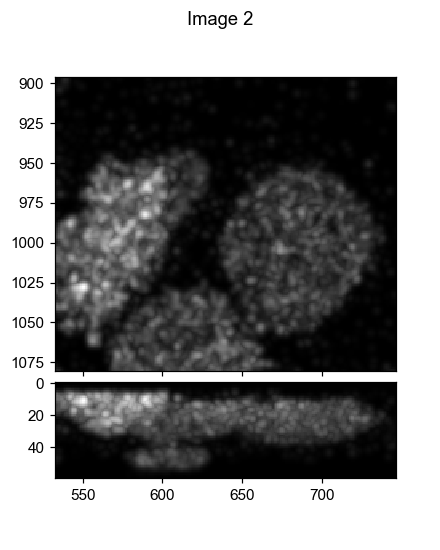

In [21]:
visual_tools.imshow_mark_3d_v2([h, ft_h, ft_h>300])